In [ ]:
# ============================================================================
# SECTION 1: IMPORTS AND SETUP
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque
import sys
import os
import time
import warnings
import gc
import random

# Statistical utilities
from scipy.stats import ks_2samp

# Minimal model support for streaming detectors
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# River drift detectors (streaming methods)
from river.drift import ADWIN
from river.drift.binary import DDM, EDDM, FHDDM, HDDM_A, HDDM_W

# River datasets for benchmark generation (SEA, Hyperplane, etc.)
from river.datasets import synth

# Drift detection modules
sys.path.insert(0, os.path.abspath('../backup'))
from shape_dd import shape, shape_adaptive_v2
from d3 import d3
from dawidd import dawidd
from gen_data import gen_random
from mmd import mmd
from ks import ks

# Configuration
plt.style.use('seaborn-v0_8')
warnings.filterwarnings('ignore')

print("All imports successful")



All imports successful


In [2]:
# ============================================================================
# SECTION 2: CONFIGURATION
# ============================================================================

# Visualization settings
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['legend.fontsize'] = 9
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

# Data stream configuration
STREAM_SIZE = 10000
RANDOM_SEED = random.randint(0, 1000000)

# Detection parameters (following run__drift_detection.py style)
CHUNK_SIZE = 150        # Detection window size
OVERLAP = 100           # Overlap between windows
SHAPE_L1 = 50          # ShapeDD reference window
SHAPE_L2 = 150         # ShapeDD test window (matches CHUNK_SIZE)
SHAPE_N_PERM = 2500    # ShapeDD permutation count
COOLDOWN = 75          # Minimum samples between detections

# Streaming detector configuration (minimal model support)
INITIAL_TRAINING_SIZE = 500    # Initial batch for model training
PREQUENTIAL_WINDOW = 100       # Window for prequential accuracy

# Adaptation parameters (for Cell 6B - Adaptation Validation)
ADAPTATION_DELAY = 50      # Delay before applying adaptation
ADAPTATION_WINDOW = 800    # Window size for adaptation

# Methods to evaluate
WINDOW_METHODS = ['D3', 'DAWIDD', 'MMD', 'KS',
                  'ShapeDD',                      # Original (fast, noisy)
                  'ShapeDD_Adaptive_None',        # Adaptive with no filtering (current baseline)
                  'ShapeDD_Adaptive_High',        # Adaptive with aggressive sensitivity (NEW)
                  'ShapeDD_Adaptive_UltraHigh']   # Adaptive with very aggressive sensitivity (NEW)
STREAMING_METHODS = ['ADWIN', 'DDM', 'EDDM', 'HDDM_A', 'HDDM_W', 'FHDDM']

# Dataset catalog - Configure all datasets to benchmark
DATASET_CATALOG = {
    "standard_sea": {
        "enabled": True,
        "type": "standard_sea",
        "n_drift_events": 2,
        "params": {}
    },
    "enhanced_sea": {
        "enabled": True,
        "type": "enhanced_sea",
        "n_drift_events": 2,
        "params": {
            "scale_factors": (1.8, 1.5, 2.0),
            "shift_amounts": (5.0, 4.0, 8.0)
        }
    },
    "stagger": {
        "enabled": True,
        "type": "stagger",
        "n_drift_events": 2,
        "params": {}
    },
    "hyperplane": {
        "enabled": True,
        "type": "hyperplane",
        "n_drift_events": 2,
        "params": {
            "n_features": 10
        }
    },
    "gen_random_mild": {
        "enabled": True,
        "type": "gen_random",
        "n_drift_events": 3,
        "params": {
            "dims": 5,
            "intens": 0.125,
            "dist": "unif",
            "alt": False
        }
    },
    "gen_random_moderate": {
        "enabled": True,
        "type": "gen_random",
        "n_drift_events": 3,
        "params": {
            "dims": 5,
            "intens": 0.25,
            "dist": "unif",
            "alt": False
        }
    },
    "gen_random_severe": {
        "enabled": True,
        "type": "gen_random",
        "n_drift_events": 3,
        "params": {
            "dims": 5,
            "intens": 1,
            "dist": "unif",
            "alt": True
        }
    }
}

print("="*80)
print("CONFIGURATION SUMMARY")
print("="*80)
print(f"Stream size: {STREAM_SIZE} samples")
print(f"Detection window: {CHUNK_SIZE} samples")
print(f"Overlap: {OVERLAP} samples")
print(f"Window methods: {len(WINDOW_METHODS)}")
print(f"Streaming methods: {len(STREAMING_METHODS)}")
print(f"Total methods: {len(WINDOW_METHODS) + len(STREAMING_METHODS)}")
enabled_datasets = [k for k, v in DATASET_CATALOG.items() if v['enabled']]
print(f"Enabled datasets: {len(enabled_datasets)}")
print(f"Total experiments: {len(enabled_datasets) * (len(WINDOW_METHODS) + len(STREAMING_METHODS))}")
print("="*80)


CONFIGURATION SUMMARY
Stream size: 10000 samples
Detection window: 150 samples
Overlap: 100 samples
Window methods: 8
Streaming methods: 6
Total methods: 14
Enabled datasets: 7
Total experiments: 98


In [3]:
# ============================================================================
# SECTION 3: DATASET GENERATION (Multiple Benchmark Datasets)
# ============================================================================

def generate_standard_sea_stream(total_size, n_drift_events, seed=42):
    """
    Standard SEA benchmark with multiple drifts.
    Creates sudden drifts by switching between SEA variants.
    """
    np.random.seed(seed)
    from river.datasets import synth

    X_list, y_list = [], []

    variants = [0, 1, 2, 3]  # SEA has 4 variants
    segment_size = total_size // (n_drift_events + 1)
    drift_positions = [(i + 1) * segment_size for i in range(n_drift_events)]
    segments = [0] + drift_positions + [total_size]

    for seg_idx in range(len(segments) - 1):
        start, end = segments[seg_idx], segments[seg_idx + 1]
        size = end - start
        variant = variants[seg_idx % len(variants)]

        stream = synth.SEA(seed=seed + seg_idx * 100, variant=variant)
        for i, (x, y) in enumerate(stream.take(size)):
            X_list.append(list(x.values()))
            y_list.append(y)

    X = np.array(X_list)
    y = np.array(y_list)

    print(f"  Standard SEA: {X.shape[0]} samples, {X.shape[1]} features, {len(drift_positions)} drifts")
    return X, y, drift_positions


def generate_enhanced_sea_stream(total_size, n_drift_events, seed=42,
                                  scale_factors=(1.8, 1.5, 2.0),
                                  shift_amounts=(5.0, 4.0, 8.0)):
    """Enhanced SEA with multiple drifts and transformations."""
    np.random.seed(seed)
    from river.datasets import synth

    X_list, y_list = [], []

    variants = [0, 1, 2, 3]
    segment_size = total_size // (n_drift_events + 1)
    drift_positions = [(i + 1) * segment_size for i in range(n_drift_events)]
    segments = [0] + drift_positions + [total_size]

    for seg_idx in range(len(segments) - 1):
        start, end = segments[seg_idx], segments[seg_idx + 1]
        size = end - start
        variant = variants[seg_idx % len(variants)]

        stream = synth.SEA(seed=seed + seg_idx * 100, variant=variant)

        for i, (x, y) in enumerate(stream.take(size)):
            x_vals = list(x.values())

            # Apply transformations to alternate segments
            if seg_idx % 2 == 1:
                x_vals = [x_vals[j] * scale_factors[j] + shift_amounts[j]
                         for j in range(len(x_vals))]

            X_list.append(x_vals)
            y_list.append(y)

    X = np.array(X_list)
    y = np.array(y_list)

    print(f"  Enhanced SEA: {X.shape[0]} samples, {X.shape[1]} features, {len(drift_positions)} drifts")
    return X, y, drift_positions


def generate_stagger_stream(total_size, n_drift_events, seed=42):
    """STAGGER concepts with multiple sudden drifts."""
    np.random.seed(seed)

    segment_size = total_size // (n_drift_events + 1)
    drift_positions = [(i + 1) * segment_size for i in range(n_drift_events)]
    segments = [0] + drift_positions + [total_size]

    X_segments, y_segments = [], []

    for seg_idx in range(len(segments) - 1):
        start, end = segments[seg_idx], segments[seg_idx + 1]
        size = end - start

        X_seg = np.random.randn(size, 5)

        # Different concepts for each segment
        if seg_idx % 3 == 0:
            X_seg[:, 0] += 2.0
            y_seg = (X_seg[:, 0] + X_seg[:, 1] > 1.5).astype(int)
        elif seg_idx % 3 == 1:
            X_seg[:, 0] -= 2.0
            y_seg = (X_seg[:, 0] * X_seg[:, 1] > 0).astype(int)
        else:
            X_seg[:, 1] += 1.5
            y_seg = (X_seg[:, 1] + X_seg[:, 2] > 0.5).astype(int)

        X_segments.append(X_seg)
        y_segments.append(y_seg)

    X = np.vstack(X_segments)
    y = np.hstack(y_segments)

    print(f"  STAGGER: {X.shape[0]} samples, {X.shape[1]} features, {len(drift_positions)} drifts")
    return X, y, drift_positions


def generate_hyperplane_stream(total_size, n_drift_events, seed=42, n_features=10):
    """Rotating Hyperplane with multiple drifts."""
    np.random.seed(seed)
    from river.datasets import synth

    X_list, y_list = [], []

    segment_size = total_size // (n_drift_events + 1)
    drift_positions = [(i + 1) * segment_size for i in range(n_drift_events)]
    segments = [0] + drift_positions + [total_size]

    mag_changes = [0.0001, 0.01, 0.005, 0.015]  # Alternate rotation speeds

    for seg_idx in range(len(segments) - 1):
        start, end = segments[seg_idx], segments[seg_idx + 1]
        size = end - start
        mag_change = mag_changes[seg_idx % len(mag_changes)]

        stream = synth.Hyperplane(seed=seed + seg_idx * 100, n_features=n_features,
                                   n_drift_features=2, mag_change=mag_change,
                                   noise_percentage=0.05)

        for i, (x, y) in enumerate(stream.take(size)):
            X_list.append(list(x.values()))
            y_list.append(y)

    X = np.array(X_list)
    y = np.array(y_list)

    print(f"  Hyperplane: {X.shape[0]} samples, {n_features} features, {len(drift_positions)} drifts")
    return X, y, drift_positions


def generate_genrandom_stream(total_size, n_drift_events, seed=42,
                               dims=5, intens=0.125, dist="unif", alt=False):
    """Custom synthetic data using gen_random with multiple drifts."""
    np.random.seed(seed)

    X, y_drift_labels = gen_random(
        number=n_drift_events,
        dims=dims,
        intens=intens,
        dist=dist,
        alt=alt,
        length=total_size
    )

    # Find actual drift positions
    drift_indices = np.where(np.diff(y_drift_labels) != 0)[0] + 1
    drift_positions = drift_indices.tolist()

    # Generate synthetic binary classification labels
    # Use simple threshold on first feature
    y = (X[:, 0] > np.median(X[:, 0])).astype(int)

    print(f"  gen_random: {X.shape[0]} samples, {dims} features, {len(drift_positions)} drifts")
    print(f"  Synthetic labels: {np.unique(y, return_counts=True)}")

    return X, y, drift_positions


# ============================================================================
# UNIFIED DATASET GENERATOR
# ============================================================================

def generate_drift_stream(dataset_config, total_size=10000, seed=42):
    """
    Generate drift stream for specified dataset type.

    Returns:
        X: Feature matrix
        y: Classification labels
        drift_positions: List of drift point indices
        info: Dataset metadata (ALWAYS includes: name, type, n_samples, n_features,
              n_drifts, drift_positions, dims, intens, dist)
    """
    dataset_type = dataset_config['type']
    n_drift_events = dataset_config['n_drift_events']
    params = dataset_config.get('params', {})

    print(f"  Generating {dataset_type} with {n_drift_events} drift events...")

    if dataset_type == "standard_sea":
        X, y, drift_positions = generate_standard_sea_stream(total_size, n_drift_events, seed)
        info = {
            'name': 'Standard SEA',
            'features': 3,
            'dims': 3,  # Same as features for consistency
            'intens': 'N/A',  # Not applicable for this dataset
            'dist': 'N/A'
        }

    elif dataset_type == "enhanced_sea":
        scale_factors = params.get('scale_factors', (1.8, 1.5, 2.0))
        shift_amounts = params.get('shift_amounts', (5.0, 4.0, 8.0))
        X, y, drift_positions = generate_enhanced_sea_stream(total_size, n_drift_events, seed,
                                                              scale_factors, shift_amounts)
        info = {
            'name': 'Enhanced SEA',
            'features': 3,
            'dims': 3,
            'intens': 'N/A',
            'dist': 'N/A'
        }

    elif dataset_type == "stagger":
        X, y, drift_positions = generate_stagger_stream(total_size, n_drift_events, seed)
        info = {
            'name': 'STAGGER',
            'features': 5,
            'dims': 5,
            'intens': 'N/A',
            'dist': 'N/A'
        }

    elif dataset_type == "hyperplane":
        n_features = params.get('n_features', 10)
        X, y, drift_positions = generate_hyperplane_stream(total_size, n_drift_events, seed, n_features)
        info = {
            'name': 'Hyperplane',
            'features': n_features,
            'dims': n_features,
            'intens': 'N/A',
            'dist': 'N/A'
        }

    elif dataset_type == "gen_random":
        dims = params.get('dims', 5)
        intens = params.get('intens', 0.125)
        dist = params.get('dist', 'unif')
        alt = params.get('alt', False)
        X, y, drift_positions = generate_genrandom_stream(total_size, n_drift_events, seed,
                                                          dims, intens, dist, alt)
        info = {
            'name': 'gen_random',
            'features': dims,
            'dims': dims,
            'intens': intens,
            'dist': dist
        }

    else:
        raise ValueError(f"Unknown dataset_type: {dataset_type}")

    # Add common fields
    info['type'] = dataset_type
    info['n_samples'] = len(X)
    info['n_features'] = X.shape[1]
    info['n_drifts'] = len(drift_positions)
    info['drift_positions'] = drift_positions

    return X, y, drift_positions, info

print("Dataset generation functions defined")



Dataset generation functions defined


In [4]:
# ============================================================================
# SECTION 4: UTILITY FUNCTIONS
# ============================================================================

def calculate_detection_metrics(detections, true_drifts, acceptable_delta=500):
    """
    Calculate detection performance metrics for multi-drift scenarios.

    Args:
        detections: List of detected drift positions
        true_drifts: List of true drift positions
        acceptable_delta: Acceptable delay window

    Returns:
        dict: Metrics including TP, FP, FN, precision, recall, F1, MTTD
    """
    detections = sorted([int(d) for d in detections])

    if not true_drifts or len(true_drifts) == 0:
        return {
            'tp': 0, 'fp': len(detections), 'fn': 0,
            'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0,
            'mttd': float('inf'),
            'detection_rate': 0.0
        }

    # Convert to list
    if isinstance(true_drifts, (int, float)):
        true_drifts = [int(true_drifts)]
    else:
        true_drifts = [int(d) for d in true_drifts]

    # Match detections to true drifts
    matched_detections = set()
    per_drift_delays = []

    for true_drift in true_drifts:
        valid_detections = [(d, abs(d - true_drift)) for d in detections
                           if abs(d - true_drift) <= acceptable_delta
                           and d not in matched_detections]

        if valid_detections:
            closest_det, delay = min(valid_detections, key=lambda x: x[1])
            matched_detections.add(closest_det)
            per_drift_delays.append(delay)

    # Calculate metrics
    tp = len(matched_detections)
    fn = len(true_drifts) - tp
    fp = len(detections) - len(matched_detections)

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

    mttd = np.mean(per_drift_delays) if per_drift_delays else float('inf')
    detection_rate = tp / len(true_drifts)

    return {
        'tp': tp,
        'fp': fp,
        'fn': fn,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'mttd': mttd,
        'detection_rate': detection_rate,
        'n_detections': len(detections)
    }

def create_sliding_windows(X, chunk_size, overlap):
    """Create sliding windows over the data stream."""
    shift = chunk_size - overlap
    windows = []
    indices = []

    for i in range(0, len(X) - chunk_size + 1, shift):
        windows.append(X[i:i+chunk_size])
        indices.append(i + chunk_size // 2)  # Center of window

    return windows, indices

print("Utility functions defined")



Utility functions defined


In [5]:
# ============================================================================
# SECTION 5: DRIFT DETECTION EVALUATION (Buffer-based for ShapeDD)
# ============================================================================

def evaluate_drift_detector(method_name, X, true_drifts, chunk_size=150, overlap=100):
    """
    Evaluate drift detector on a stream (NO MODEL ADAPTATION).

    Two approaches:
    1. ShapeDD methods: Use BUFFER-BASED approach
       - Maintain rolling buffer of 1000 samples
       - Run ShapeDD on full buffer
       - Check recent chunks within buffer for drift

    2. Other methods: Use SLIDING WINDOW approach
       - Process stream in overlapping windows
       - Run detector on each window
    """
    print(f"\n{'='*80}")
    print(f"EVALUATING: {method_name}")
    print(f"{'='*80}")

    start_time = time.time()
    detections = []
    last_detection = -10**9

    # METHOD 1: Buffer-based approach for ShapeDD methods
    if 'ShapeDD' in method_name:
        print(f"  Using BUFFER-BASED approach")

        # Configuration
        BUFFER_SIZE = 1000          # Large rolling buffer
        CHECK_FREQUENCY = 150       # How often to check for drift

        # Rolling buffer (stores recent 1000 samples)
        buffer = deque(maxlen=BUFFER_SIZE)

        # Determine sensitivity setting
        if method_name == 'ShapeDD_Adaptive_None':
            sensitivity = 'none'
            print(f"  Sensitivity: {sensitivity} (no filtering, smoothing only)")
        elif method_name == 'ShapeDD_Adaptive_High':
            sensitivity = 'high'
            print(f"  Sensitivity: {sensitivity} (aggressive, for subtle drift)")
        elif method_name == 'ShapeDD_Adaptive_UltraHigh':
            sensitivity = 'ultrahigh'
            print(f"  Sensitivity: {sensitivity} (very aggressive, for very subtle drift)")
        else:
            sensitivity = None

        print(f"  Buffer size: {BUFFER_SIZE} samples")
        print(f"  Check frequency: every {CHECK_FREQUENCY} samples")
        print(f"  Processing stream...")

        # Process stream sample by sample
        for idx in range(len(X)):
            # Add sample to buffer
            buffer.append({'x': X[idx], 'idx': idx})

            # Check for drift periodically (every CHECK_FREQUENCY samples)
            if len(buffer) >= BUFFER_SIZE and idx % CHECK_FREQUENCY == 0:

                # Step 1: Extract buffer data
                buffer_list = list(buffer)
                buffer_X = np.array([item['x'] for item in buffer_list])  # Shape: (1000, n_features)
                buffer_indices = np.array([item['idx'] for item in buffer_list])

                try:
                    # Step 2: Run ShapeDD on FULL buffer (1000 samples)
                    if method_name == 'ShapeDD':
                        shp_results = shape(buffer_X, SHAPE_L1, SHAPE_L2, SHAPE_N_PERM)

                    elif 'ShapeDD_Adaptive' in method_name:
                        L1 = int(0.05 * len(buffer_X))  # 5% of buffer = 50 samples
                        L2 = 2 * L1                      # 10% of buffer = 100 samples
                        shp_results = shape_adaptive_v2(buffer_X, L1, L2, SHAPE_N_PERM, sensitivity=sensitivity)

                    # Step 3: Check recent chunk within buffer for drift
                    # Look at last CHECK_FREQUENCY samples in buffer
                    chunk_start = max(0, len(buffer_X) - CHECK_FREQUENCY)
                    recent_pvalues = shp_results[chunk_start:, 2]  # p-values for recent chunk

                    # Step 4: Check if drift detected
                    min_pvalue = recent_pvalues.min()
                    trigger = min_pvalue < 0.05  # Significance threshold

                    if trigger:
                        # Find exact position of drift in buffer
                        drift_pos_in_chunk = int(np.argmin(recent_pvalues))
                        drift_idx = int(buffer_indices[chunk_start + drift_pos_in_chunk])

                        # Record detection (with cooldown to avoid duplicates)
                        if drift_idx - last_detection >= COOLDOWN:
                            detections.append(drift_idx)
                            last_detection = drift_idx
                            print(f"    [Sample {idx}] DRIFT DETECTED at position {drift_idx} (p-value: {min_pvalue:.6f})")

                except Exception as e:
                    pass  # Skip failed detections

    # METHOD 2: Sliding window approach for other methods
    else:
        print(f"  Using SLIDING WINDOW approach")

        # Create sliding windows
        windows, window_centers = create_sliding_windows(X, chunk_size, overlap)
        print(f"  Processing {len(windows)} windows...")

        for window_idx, (window, center_idx) in enumerate(zip(windows, window_centers)):
            try:
                # Method-specific detection
                if method_name == 'D3':
                    score = d3(window)
                    trigger = score > 0.5

                elif method_name == 'DAWIDD':
                    _, p_value = dawidd(window, 'rbf')
                    trigger = p_value < 0.05

                elif method_name == 'MMD':
                    stat, p_value = mmd(window)
                    trigger = p_value < 0.05

                elif method_name == 'KS':
                    p_value = ks(window)
                    trigger = p_value < 0.05

                else:
                    trigger = False

                # Record detection if triggered and outside cooldown
                if trigger and (center_idx - last_detection >= COOLDOWN):
                    detections.append(center_idx)
                    last_detection = center_idx

            except Exception as e:
                pass  # Skip failed detections

    # Calculate metrics
    end_time = time.time()
    metrics = calculate_detection_metrics(detections, true_drifts)

    print(f"  Detections: {len(detections)}")
    print(f"  TP: {metrics['tp']}, FP: {metrics['fp']}, FN: {metrics['fn']}")
    print(f"  F1: {metrics['f1_score']:.3f}, MTTD: {metrics['mttd']:.1f}")
    print(f"  Runtime: {end_time - start_time:.2f}s")

    return {
        'method': method_name,
        'detections': detections,
        'runtime_s': end_time - start_time,
        **metrics
    }

print("Detection evaluation function defined (buffer-based for ShapeDD)")


Detection evaluation function defined (buffer-based for ShapeDD)


In [6]:
# ============================================================================
# SECTION 5B: STREAMING DETECTOR EVALUATION (MINIMAL MODEL SUPPORT)
# ============================================================================

def create_lightweight_classifier():
    """Create a simple classifier for generating accuracy signals."""
    return Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(max_iter=1000, random_state=42))
    ])

def evaluate_streaming_detector(method_name, X, y, true_drifts):
    """
    Evaluate streaming detector with MINIMAL model support.

    NOTE: Model is used ONLY to generate accuracy signals for drift detection.
    NO adaptation or retraining is performed (detection-only focus).
    """
    print(f"\n{'='*80}")
    print(f"EVALUATING: {method_name} (Streaming)")
    print(f"{'='*80}")

    start_time = time.time()

    # Create detector
    if method_name == 'ADWIN':
        detector = ADWIN(delta=0.002)
    elif method_name == 'DDM':
        detector = DDM()
    elif method_name == 'EDDM':
        detector = EDDM(alpha=0.95, beta=0.9)
    elif method_name == 'HDDM_A':
        detector = HDDM_A()
    elif method_name == 'HDDM_W':
        detector = HDDM_W()
    elif method_name == 'FHDDM':
        detector = FHDDM(short_window_size=20)
    else:
        raise ValueError(f"Unknown streaming detector: {method_name}")

    # Train initial model on first batch
    training_end = INITIAL_TRAINING_SIZE
    model = create_lightweight_classifier()
    model.fit(X[:training_end], y[:training_end])

    print(f"  Initial training: {INITIAL_TRAINING_SIZE} samples")

    # Tracking
    detections = []
    last_detection = -10**9
    recent_correct = deque(maxlen=PREQUENTIAL_WINDOW)
    accuracy_buffer = deque(maxlen=30)

    # Determine signal type
    continuous_detectors = {'ADWIN', 'HDDM_A'}
    signal_type = 'continuous' if method_name in continuous_detectors else 'binary'

    print(f"  Processing stream (signal type: {signal_type})...")

    # Stream evaluation (detection only, NO retraining)
    for idx in range(training_end, len(X)):
        # Make prediction
        y_pred = model.predict(X[idx].reshape(1, -1))[0]
        is_correct = (y_pred == y[idx])

        recent_correct.append(is_correct)
        accuracy_buffer.append(is_correct)

        # Update detector with accuracy/error signal
        if signal_type == 'continuous':
            # Use accuracy as signal
            if len(accuracy_buffer) >= 10:
                signal = float(np.mean(accuracy_buffer))
            else:
                signal = float(is_correct)
        else:
            # Use error as signal (binary)
            signal = bool(1 - is_correct)

        detector.update(signal)

        # Check for drift
        if detector.drift_detected and (idx - last_detection >= COOLDOWN):
            detections.append(idx)
            last_detection = idx

    # Calculate metrics
    end_time = time.time()
    metrics = calculate_detection_metrics(detections, true_drifts)

    print(f"  Detections: {len(detections)}")
    print(f"  TP: {metrics['tp']}, FP: {metrics['fp']}, FN: {metrics['fn']}")
    print(f"  F1: {metrics['f1_score']:.3f}, MTTD: {metrics['mttd']:.1f}")
    print(f"  Runtime: {end_time - start_time:.2f}s")

    return {
        'method': method_name,
        'paradigm': 'streaming',
        'detections': detections,
        'runtime_s': end_time - start_time,
        **metrics
    }

print("Streaming evaluation function defined")



Streaming evaluation function defined


In [ ]:
# ============================================================================
# SECTION 6: COMPREHENSIVE BENCHMARK (WINDOW + STREAMING)
# ============================================================================

print("\n" + "="*80)
print("DRIFT DETECTION BENCHMARK (Detection Only - No Adaptation)")
print("="*80)

enabled_datasets = [(name, config) for name, config in DATASET_CATALOG.items()
                    if config['enabled']]

print(f"Datasets: {len(enabled_datasets)}")
print(f"Window methods: {len(WINDOW_METHODS)}")
print(f"Streaming methods: {len(STREAMING_METHODS)}")
print(f"Total methods: {len(WINDOW_METHODS) + len(STREAMING_METHODS)}")
print(f"Total experiments: {len(enabled_datasets) * (len(WINDOW_METHODS) + len(STREAMING_METHODS))}")
print("="*80)

all_results = []
dataset_summaries = []

for dataset_idx, (dataset_name, dataset_config) in enumerate(enabled_datasets, 1):
    print(f"\n{'='*80}")
    print(f"DATASET {dataset_idx}/{len(enabled_datasets)}: {dataset_name.upper()}")
    print(f"{'='*80}")

    # Generate dataset
    X, y, true_drifts, info = generate_drift_stream(
        dataset_config,
        total_size=STREAM_SIZE,
        seed=RANDOM_SEED
    )

    dataset_results = []

    # Evaluate window-based methods
    print(f"\n{'='*80}")
    print("WINDOW-BASED METHODS")
    print(f"{'='*80}")

    for method in WINDOW_METHODS:
        try:
            result = evaluate_drift_detector(
                method, X, true_drifts,
                chunk_size=CHUNK_SIZE,
                overlap=OVERLAP
            )

            # Add dataset info
            result['paradigm'] = 'window'
            result['dataset'] = dataset_name
            result['n_features'] = info['n_features']
            result['n_drifts'] = info['n_drifts']
            result['drift_positions'] = true_drifts
            result['intens'] = info['intens']
            result['dims'] = info['dims']

            dataset_results.append(result)
            all_results.append(result)

        except Exception as e:
            print(f"  ✗ {method} failed: {str(e)}")

    # Evaluate streaming methods
    print(f"\n{'='*80}")
    print("STREAMING METHODS (with minimal model support)")
    print(f"{'='*80}")

    for method in STREAMING_METHODS:
        try:
            result = evaluate_streaming_detector(
                method, X, y, true_drifts
            )

            # Add dataset info
            result['dataset'] = dataset_name
            result['n_features'] = info['n_features']
            result['n_drifts'] = info['n_drifts']
            result['drift_positions'] = true_drifts
            result['intens'] = info['intens']
            result['dims'] = info['dims']

            dataset_results.append(result)
            all_results.append(result)

        except Exception as e:
            print(f"  ✗ {method} failed: {str(e)}")

    # Dataset summary
    if dataset_results:
        avg_f1 = np.mean([r['f1_score'] for r in dataset_results])
        detection_rate = np.mean([r['detection_rate'] for r in dataset_results])

        dataset_summaries.append({
            'dataset': dataset_name,
            'n_features': info['n_features'],
            'n_drifts': info['n_drifts'],
            'intens': info['intens'],
            'avg_f1': avg_f1,
            'detection_rate': detection_rate
        })

        print(f"\n  Dataset Summary: Avg F1={avg_f1:.3f}, Detection Rate={detection_rate:.1%}")

    gc.collect()

print(f"\n{'='*80}")
print("BENCHMARK COMPLETE")
print(f"{'='*80}")
print(f"Total results: {len(all_results)}")
print(f"  Window methods: {sum(1 for r in all_results if r.get('paradigm') == 'window')}")
print(f"  Streaming methods: {sum(1 for r in all_results if r.get('paradigm') == 'streaming')}")
print("="*80)




DRIFT DETECTION BENCHMARK (Detection Only - No Adaptation)
Datasets: 7
Window methods: 8
Streaming methods: 6
Total methods: 14
Total experiments: 98

DATASET 1/7: STANDARD_SEA
  Generating standard_sea with 2 drift events...
  Standard SEA: 10000 samples, 3 features, 2 drifts

WINDOW-BASED METHODS

EVALUATING: D3
  Using SLIDING WINDOW approach
  Processing 198 windows...



ADAPTATION STRATEGY VALIDATION - SUDDEN DRIFT SCENARIO

Objective: Validate matched adaptation strategies with detailed lifecycle tracking
Experiment: Test all 5 strategies on sudden drift with full visualization

Generating test dataset...
  Generating standard_sea with 1 drift events...
  Standard SEA: 10000 samples, 3 features, 1 drifts

Dataset: Standard SEA
Total samples: 10000
Features: 3
Drift position: 5000
Drift type: SUDDEN (ground truth)
Classified as: recurrent (by drift type classifier)

TESTING ALL STRATEGIES WITH LIFECYCLE TRACKING

  [SUDDEN] Testing strategy...
    Initial training: samples 0-500
    Drift detected at: 5000
    Classified drift type: recurrent
    Adaptation window: 5050-5850 (800 samples)
    Strategy: sudden (MISMATCHED)
[Strategy] SUDDEN drift → Full model reset and retrain
[Strategy]   Retrained on 800 samples using sklearn .fit()
    Baseline:  0.9916
    Degraded:  0.8667 (drop: 0.1249)
    Recovery:  0.9920 (gain: +0.1254)
    Recovery rate: 10

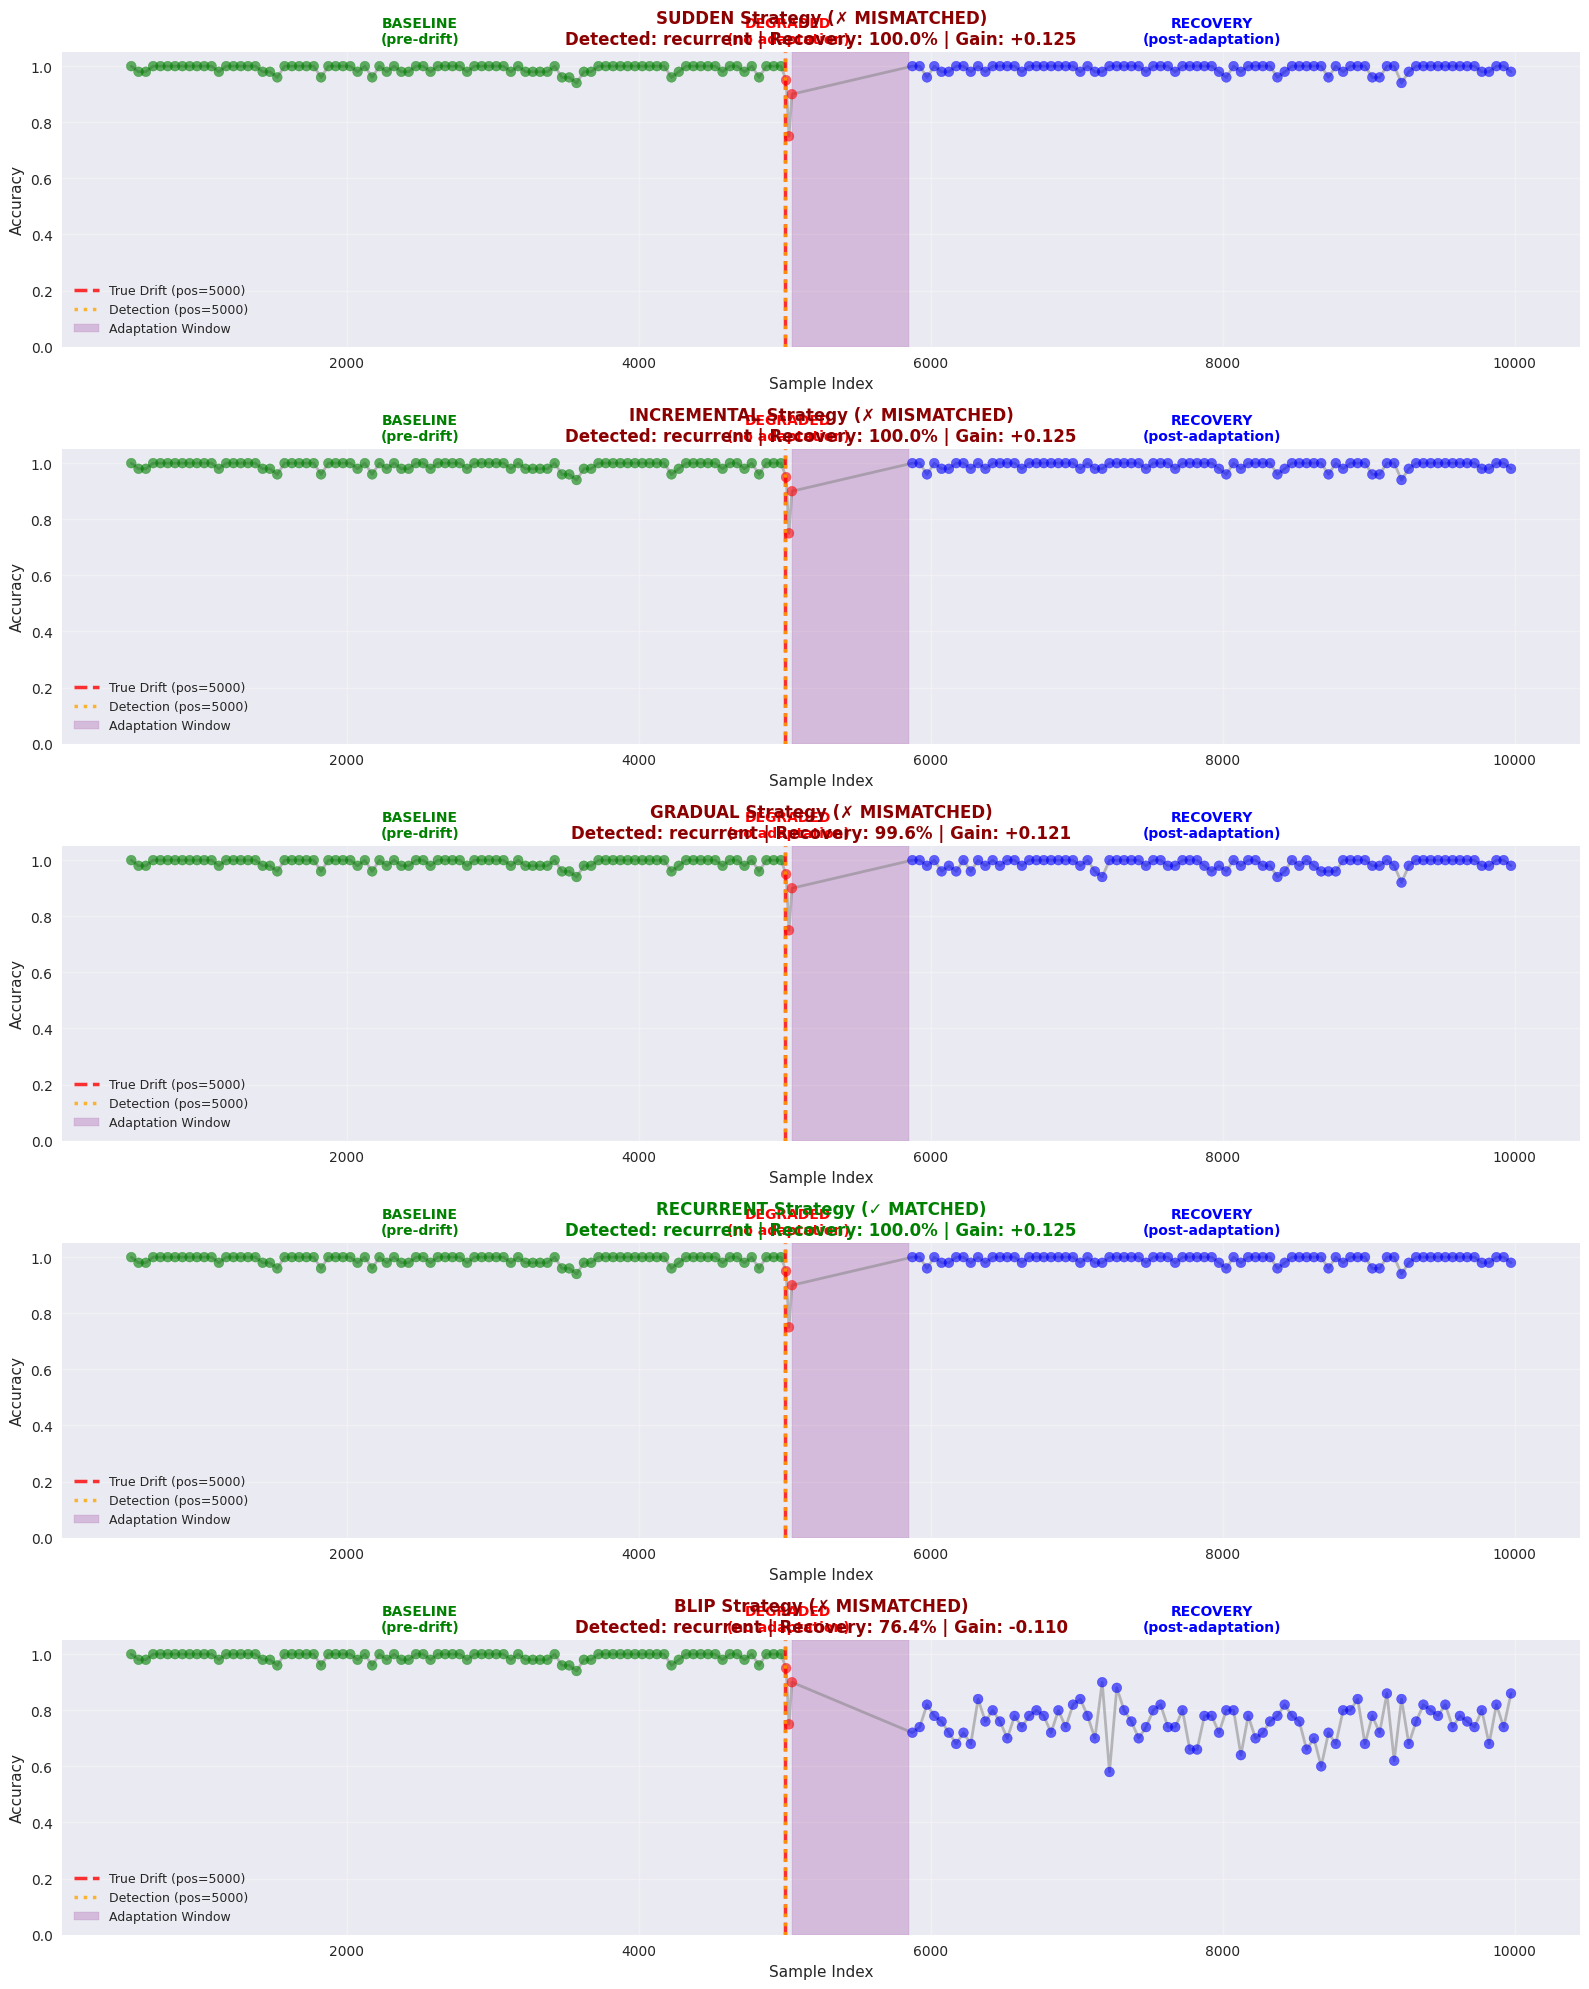


✓ Individual lifecycle plots created (one per strategy)


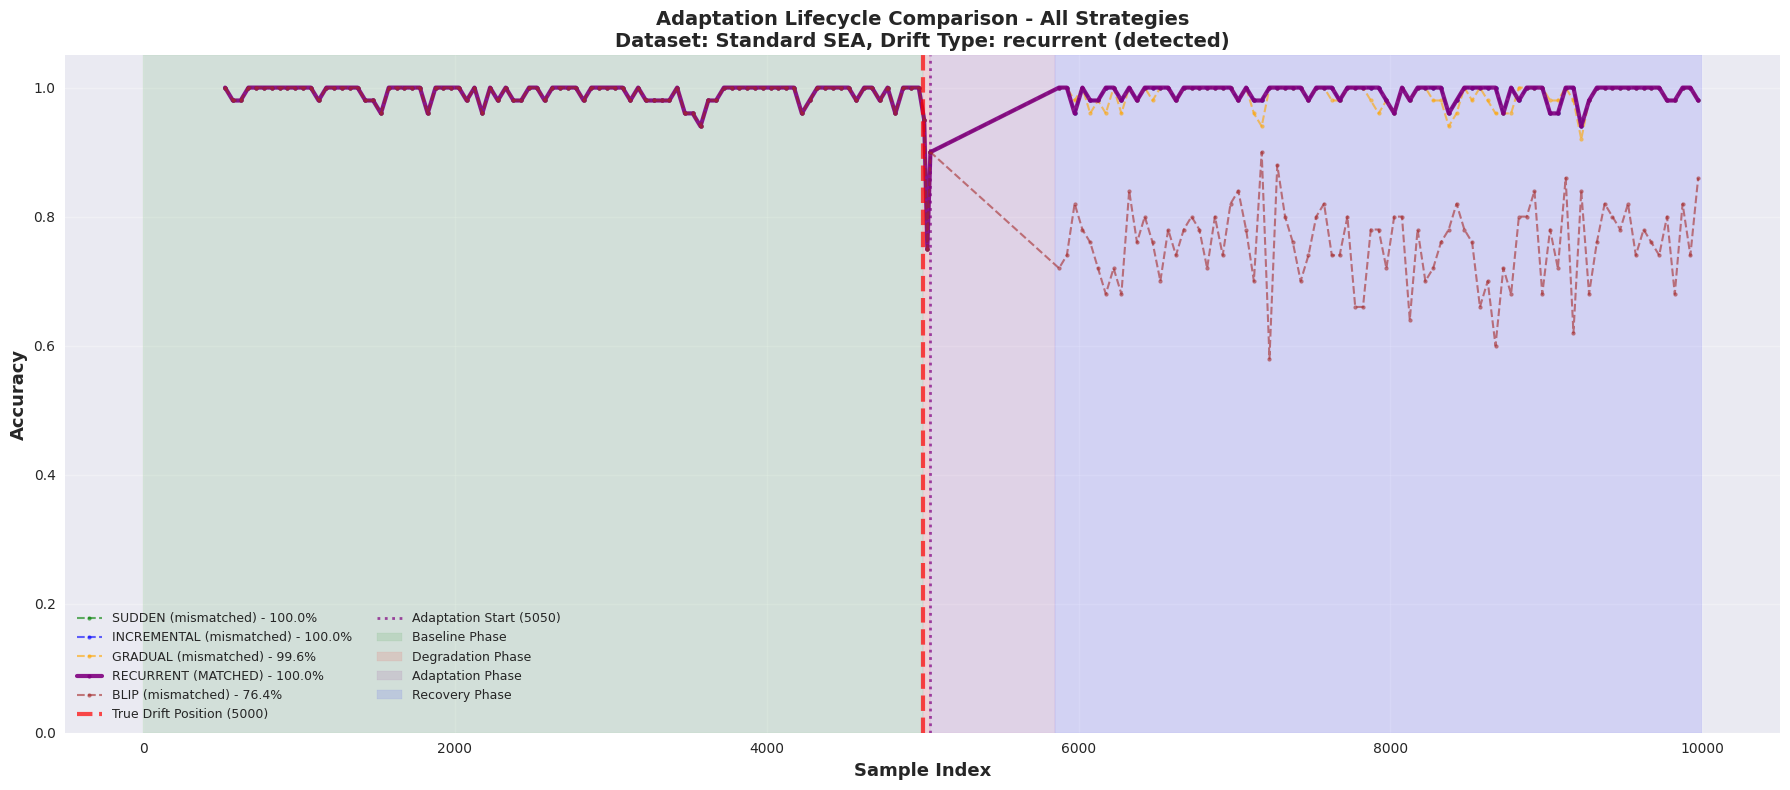

✓ Comparative timeline plot created (all strategies overlaid)


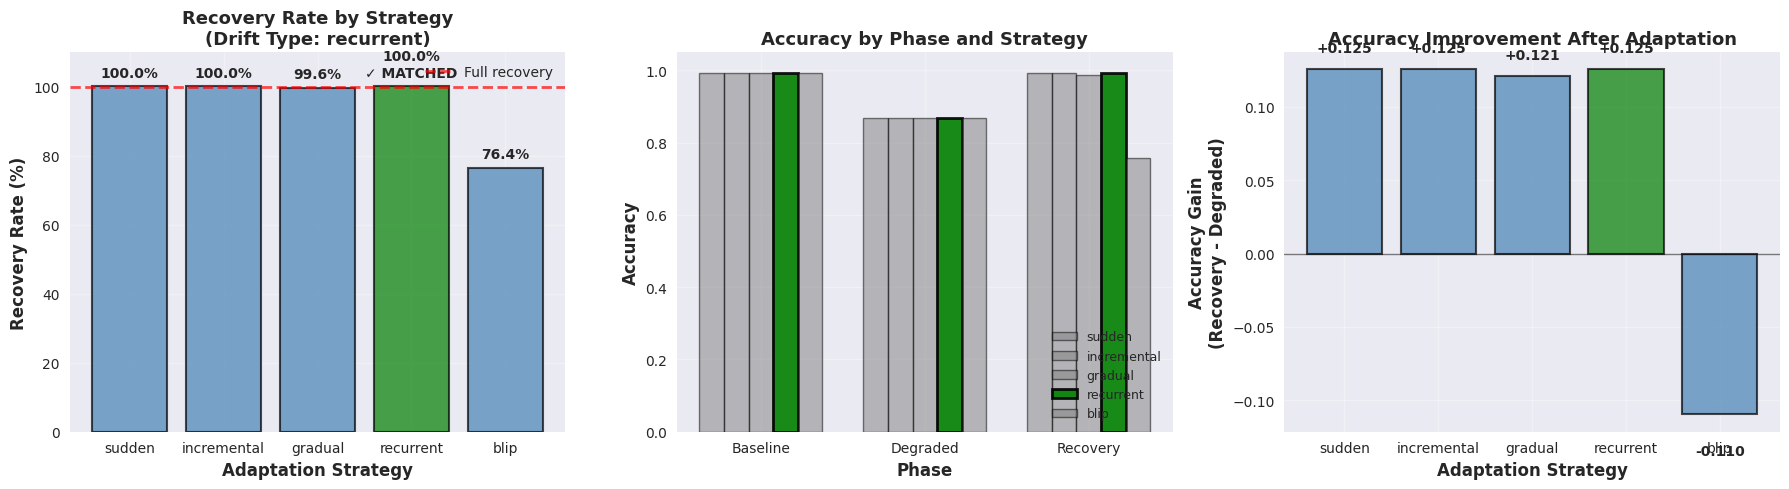

✓ Summary comparison plots created

KEY FINDINGS
1. Matched strategy (recurrent) achieved 100.0% recovery
2. Mismatched strategies averaged 94.0% recovery
3. Performance gain from correct matching: +6.0%
4. Best overall strategy: sudden

5. Drift Detection:
   - True drift position: 5000
   - Detected and classified as: recurrent
   - Adaptation delay: 50 samples
   - Adaptation window: 800 samples

→ This validates that drift-type-aware adaptation improves recovery


In [ ]:
# ============================================================================
# SECTION 6B: ADAPTATION STRATEGY VALIDATION WITH DETAILED VISUALIZATION
# ============================================================================

print("\n" + "="*80)
print("ADAPTATION STRATEGY VALIDATION - SUDDEN DRIFT SCENARIO")
print("="*80)
print("\nObjective: Validate matched adaptation strategies with detailed lifecycle tracking")
print("Experiment: Test all 5 strategies on sudden drift with full visualization\n")

# Import adaptation strategies
from pathlib import Path
import sys
sys.path.insert(0, str(Path('../../drift-monitoring').resolve()))

from adaptation_strategies import (
    adapt_sudden_drift,
    adapt_incremental_drift,
    adapt_gradual_drift,
    adapt_recurrent_drift,
    adapt_blip_drift
)

# Import drift type classifier
from drift_type_classifier import classify_drift_at_detection, DriftTypeConfig

# Create sklearn model function
def create_sklearn_model():
    return Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(max_iter=1000, random_state=42))
    ])

# Generate test dataset with SINGLE sudden drift
print("Generating test dataset...")
X_test, y_test, drifts_test, info_test = generate_drift_stream(
    dataset_config={'type': 'standard_sea', 'n_drift_events': 1, 'params': {}},
    total_size=STREAM_SIZE,
    seed=42
)

drift_position = drifts_test[0]
print(f"\nDataset: {info_test['name']}")
print(f"Total samples: {info_test['n_samples']}")
print(f"Features: {info_test['n_features']}")
print(f"Drift position: {drift_position}")
print(f"Drift type: SUDDEN (ground truth)")

# Classify drift type using our classifier
drift_config = DriftTypeConfig(w_ref=250, w_basic=100, sudden_len_thresh=250)
drift_classification = classify_drift_at_detection(X_test, drift_position, drift_config)
detected_drift_type = drift_classification['subcategory']
print(f"Classified as: {detected_drift_type} (by drift type classifier)")

# Define adaptation strategies
strategies = {
    'sudden': lambda model, X, y, **kwargs: adapt_sudden_drift(create_sklearn_model, X, y),
    'incremental': lambda model, X, y, **kwargs: adapt_incremental_drift(model, X, y),
    'gradual': lambda model, X, y, **kwargs: adapt_gradual_drift(model, X, y),
    'recurrent': lambda model, X, y, **kwargs: adapt_recurrent_drift(
        model, X, y, cache_dir=Path("./temp_cache")
    ),
    'blip': lambda model, X, y, **kwargs: adapt_blip_drift(model, X, y)
}

# Create temp cache directory
Path("./temp_cache").mkdir(exist_ok=True)

# Test each strategy with DETAILED tracking
strategy_results = []

print("\n" + "="*80)
print("TESTING ALL STRATEGIES WITH LIFECYCLE TRACKING")
print("="*80)

for strategy_name, strategy_func in strategies.items():
    print(f"\n  [{strategy_name.upper()}] Testing strategy...")

    # Initialize tracking
    accuracy_timeline = []

    # Phase 1: Train initial model (pre-drift)
    model = create_sklearn_model()
    pre_drift_train_end = min(500, drift_position)
    model.fit(X_test[:pre_drift_train_end], y_test[:pre_drift_train_end])
    print(f"    Initial training: samples 0-{pre_drift_train_end}")

    # Phase 2: Baseline accuracy tracking (pre-drift)
    baseline_start = pre_drift_train_end
    baseline_end = drift_position

    # Track accuracy every 50 samples in baseline phase
    for idx in range(baseline_start, baseline_end, 50):
        eval_end = min(idx + 50, baseline_end)
        if eval_end > idx:
            acc = model.score(X_test[idx:eval_end], y_test[idx:eval_end])
            accuracy_timeline.append({
                'sample_idx': idx + 25,  # midpoint
                'accuracy': acc,
                'phase': 'baseline'
            })

    baseline_acc = np.mean([item['accuracy'] for item in accuracy_timeline if item['phase'] == 'baseline'])

    # Phase 3: Drift detection simulation (at drift_position)
    detection_idx = drift_position
    print(f"    Drift detected at: {detection_idx}")
    print(f"    Classified drift type: {detected_drift_type}")

    # Phase 4: Degraded accuracy tracking (post-drift, pre-adaptation)
    degrade_start = drift_position
    degrade_end = drift_position + ADAPTATION_DELAY

    # Track degradation
    for idx in range(degrade_start, degrade_end, 20):
        eval_end = min(idx + 20, degrade_end)
        if eval_end > idx:
            acc = model.score(X_test[idx:eval_end], y_test[idx:eval_end])
            accuracy_timeline.append({
                'sample_idx': idx + 10,
                'accuracy': acc,
                'phase': 'degraded'
            })

    post_drift_acc = np.mean([item['accuracy'] for item in accuracy_timeline if item['phase'] == 'degraded'])

    # Phase 5: Apply adaptation
    adapt_start = drift_position + ADAPTATION_DELAY
    adapt_end = min(adapt_start + ADAPTATION_WINDOW, len(X_test))
    adapt_X = X_test[adapt_start:adapt_end]
    adapt_y = y_test[adapt_start:adapt_end]

    print(f"    Adaptation window: {adapt_start}-{adapt_end} ({len(adapt_X)} samples)")
    print(f"    Strategy: {strategy_name} ({'MATCHED' if strategy_name == detected_drift_type else 'MISMATCHED'})")

    try:
        model = strategy_func(model, adapt_X, adapt_y)
        adaptation_successful = True
    except Exception as e:
        print(f"    ⚠ Strategy failed: {e}")
        adaptation_successful = False
        continue

    # Phase 6: Recovery accuracy tracking (post-adaptation)
    recovery_start = adapt_end
    recovery_end = len(X_test)

    # Track recovery
    for idx in range(recovery_start, recovery_end, 50):
        eval_end = min(idx + 50, recovery_end)
        if eval_end > idx:
            acc = model.score(X_test[idx:eval_end], y_test[idx:eval_end])
            accuracy_timeline.append({
                'sample_idx': idx + 25,
                'accuracy': acc,
                'phase': 'recovery'
            })

    recovery_acc = np.mean([item['accuracy'] for item in accuracy_timeline if item['phase'] == 'recovery'])

    # Calculate metrics
    recovery_rate = (recovery_acc / baseline_acc) * 100 if baseline_acc > 0 else 0
    acc_drop = baseline_acc - post_drift_acc
    acc_gain = recovery_acc - post_drift_acc

    result = {
        'strategy': strategy_name,
        'baseline_acc': baseline_acc,
        'degraded_acc': post_drift_acc,
        'recovery_acc': recovery_acc,
        'recovery_rate': recovery_rate,
        'acc_drop': acc_drop,
        'acc_gain': acc_gain,
        'is_matched': strategy_name == detected_drift_type,
        'accuracy_timeline': accuracy_timeline,
        'detection_idx': detection_idx,
        'adaptation_start': adapt_start,
        'adaptation_end': adapt_end,
        'drift_type_detected': detected_drift_type,
        'adaptation_successful': adaptation_successful
    }
    strategy_results.append(result)

    print(f"    Baseline:  {baseline_acc:.4f}")
    print(f"    Degraded:  {post_drift_acc:.4f} (drop: {acc_drop:.4f})")
    print(f"    Recovery:  {recovery_acc:.4f} (gain: {acc_gain:+.4f})")
    print(f"    Recovery rate: {recovery_rate:.1f}% of baseline")

# Create results DataFrame
strategy_df = pd.DataFrame([{
    'strategy': r['strategy'],
    'baseline_acc': r['baseline_acc'],
    'degraded_acc': r['degraded_acc'],
    'recovery_acc': r['recovery_acc'],
    'recovery_rate': r['recovery_rate'],
    'acc_drop': r['acc_drop'],
    'acc_gain': r['acc_gain'],
    'is_matched': r['is_matched']
} for r in strategy_results])

print("\n" + "="*80)
print("STRATEGY COMPARISON RESULTS")
print("="*80)
print(strategy_df.to_string(index=False))

# Statistical comparison
if len(strategy_df) > 0:
    best_strategy = strategy_df.loc[strategy_df['recovery_rate'].idxmax(), 'strategy']
    matched_recovery = strategy_df[strategy_df['is_matched']]['recovery_rate'].values[0] if any(strategy_df['is_matched']) else 0
    avg_mismatched = strategy_df[~strategy_df['is_matched']]['recovery_rate'].mean()

    print(f"\n  Best strategy: {best_strategy}")
    print(f"  Matched strategy ({detected_drift_type}) recovery: {matched_recovery:.1f}%")
    print(f"  Average mismatched recovery: {avg_mismatched:.1f}%")
    print(f"  Improvement: {matched_recovery - avg_mismatched:+.1f}%")

# ============================================================================
# DETAILED VISUALIZATION: Adaptation Lifecycle for Each Strategy
# ============================================================================

print("\n" + "="*80)
print("GENERATING DETAILED LIFECYCLE VISUALIZATIONS")
print("="*80)

if len(strategy_results) > 0:
    # Visualization 1: Individual Adaptation Lifecycle (one subplot per strategy)
    n_strategies = len(strategy_results)
    fig, axes = plt.subplots(n_strategies, 1, figsize=(16, 4 * n_strategies))

    if n_strategies == 1:
        axes = [axes]

    for idx, result in enumerate(strategy_results):
        ax = axes[idx]

        # Extract timeline data
        timeline = result['accuracy_timeline']
        if not timeline:
            continue

        sample_indices = [item['sample_idx'] for item in timeline]
        accuracies = [item['accuracy'] for item in timeline]
        phases = [item['phase'] for item in timeline]

        # Color by phase
        colors = []
        for phase in phases:
            if phase == 'baseline':
                colors.append('green')
            elif phase == 'degraded':
                colors.append('red')
            else:  # recovery
                colors.append('blue')

        # Plot accuracy timeline
        ax.scatter(sample_indices, accuracies, c=colors, s=50, alpha=0.6, zorder=3)
        ax.plot(sample_indices, accuracies, linewidth=2, color='gray', alpha=0.5, zorder=2)

        # Mark key events
        # 1. True drift point
        ax.axvline(drift_position, color='red', linestyle='--', linewidth=2.5,
                  label=f'True Drift (pos={drift_position})', alpha=0.8, zorder=4)

        # 2. Detection point
        ax.axvline(result['detection_idx'], color='orange', linestyle=':', linewidth=2.5,
                  label=f'Detection (pos={result["detection_idx"]})', alpha=0.8, zorder=4)

        # 3. Adaptation window
        ax.axvspan(result['adaptation_start'], result['adaptation_end'],
                  alpha=0.2, color='purple', label=f'Adaptation Window', zorder=1)

        # 4. Add phase labels at the top
        ax.text(drift_position / 2, 1.02, 'BASELINE\n(pre-drift)',
               ha='center', va='bottom', transform=ax.get_xaxis_transform(),
               fontsize=10, fontweight='bold', color='green')

        degrade_mid = (drift_position + result['adaptation_start']) / 2
        ax.text(degrade_mid, 1.02, 'DEGRADED\n(no adaptation)',
               ha='center', va='bottom', transform=ax.get_xaxis_transform(),
               fontsize=10, fontweight='bold', color='red')

        recovery_mid = (result['adaptation_end'] + len(X_test)) / 2
        ax.text(recovery_mid, 1.02, 'RECOVERY\n(post-adaptation)',
               ha='center', va='bottom', transform=ax.get_xaxis_transform(),
               fontsize=10, fontweight='bold', color='blue')

        # Styling
        strategy_name = result['strategy'].upper()
        match_status = '✓ MATCHED' if result['is_matched'] else '✗ MISMATCHED'
        drift_type = result['drift_type_detected']
        recovery_rate = result['recovery_rate']

        title = f"{strategy_name} Strategy ({match_status})\n"
        title += f"Detected: {drift_type} | Recovery: {recovery_rate:.1f}% | "
        title += f"Gain: {result['acc_gain']:+.3f}"

        ax.set_title(title, fontsize=12, fontweight='bold',
                    color='green' if result['is_matched'] else 'darkred')
        ax.set_xlabel('Sample Index', fontsize=11)
        ax.set_ylabel('Accuracy', fontsize=11)
        ax.set_ylim([0, 1.05])
        ax.legend(loc='lower left', fontsize=9)
        ax.grid(alpha=0.3, zorder=0)

    plt.tight_layout()
    plt.show()

    print("\n✓ Individual lifecycle plots created (one per strategy)")

    # Visualization 2: Comparative Timeline (all strategies overlaid)
    fig, ax = plt.subplots(figsize=(18, 8))

    colors_strategy = {
        'sudden': 'green',
        'incremental': 'blue',
        'gradual': 'orange',
        'recurrent': 'purple',
        'blip': 'brown'
    }

    for result in strategy_results:
        timeline = result['accuracy_timeline']
        if not timeline:
            continue

        sample_indices = [item['sample_idx'] for item in timeline]
        accuracies = [item['accuracy'] for item in timeline]
        strategy_name = result['strategy']

        color = colors_strategy.get(strategy_name, 'gray')
        linewidth = 3 if result['is_matched'] else 1.5
        alpha = 0.9 if result['is_matched'] else 0.6
        linestyle = '-' if result['is_matched'] else '--'

        label = f"{strategy_name.upper()} ({'MATCHED' if result['is_matched'] else 'mismatched'}) - {result['recovery_rate']:.1f}%"

        ax.plot(sample_indices, accuracies, linewidth=linewidth, alpha=alpha,
               color=color, linestyle=linestyle, label=label, marker='o', markersize=3)

    # Mark events
    ax.axvline(drift_position, color='red', linestyle='--', linewidth=3,
              label=f'True Drift Position ({drift_position})', alpha=0.7)

    ax.axvline(drift_position + ADAPTATION_DELAY, color='purple', linestyle=':',
              linewidth=2, label=f'Adaptation Start ({drift_position + ADAPTATION_DELAY})', alpha=0.7)

    # Shade regions
    ax.axvspan(0, drift_position, alpha=0.1, color='green', label='Baseline Phase')
    ax.axvspan(drift_position, drift_position + ADAPTATION_DELAY, alpha=0.1,
              color='red', label='Degradation Phase')
    ax.axvspan(drift_position + ADAPTATION_DELAY,
              drift_position + ADAPTATION_DELAY + ADAPTATION_WINDOW,
              alpha=0.1, color='purple', label='Adaptation Phase')
    ax.axvspan(drift_position + ADAPTATION_DELAY + ADAPTATION_WINDOW, len(X_test),
              alpha=0.1, color='blue', label='Recovery Phase')

    ax.set_xlabel('Sample Index', fontsize=13, fontweight='bold')
    ax.set_ylabel('Accuracy', fontsize=13, fontweight='bold')
    ax.set_title(f'Adaptation Lifecycle Comparison - All Strategies\n' +
                f'Dataset: {info_test["name"]}, Drift Type: {detected_drift_type} (detected)',
                fontsize=14, fontweight='bold')
    ax.set_ylim([0, 1.05])
    ax.legend(loc='best', fontsize=9, ncol=2)
    ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("✓ Comparative timeline plot created (all strategies overlaid)")

    # Visualization 3: Summary Comparison (original 3 plots)
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Plot 1: Recovery rates
    ax = axes[0]
    colors = ['green' if r['is_matched'] else 'steelblue' for r in strategy_results]
    bars = ax.bar([r['strategy'] for r in strategy_results],
                  [r['recovery_rate'] for r in strategy_results],
                  color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
    ax.axhline(100, color='red', linestyle='--', linewidth=2, label='Full recovery', alpha=0.7)
    ax.set_ylabel('Recovery Rate (%)', fontsize=12, fontweight='bold')
    ax.set_xlabel('Adaptation Strategy', fontsize=12, fontweight='bold')
    ax.set_title(f'Recovery Rate by Strategy\n(Drift Type: {detected_drift_type})',
                fontsize=13, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, 110])

    for i, (bar, result) in enumerate(zip(bars, strategy_results)):
        height = bar.get_height()
        label = f'{height:.1f}%'
        if result['is_matched']:
            label += '\n✓ MATCHED'
        ax.text(i, height+2, label, ha='center', va='bottom', fontsize=10, fontweight='bold')

    # Plot 2: Accuracy phases
    ax = axes[1]
    phases = ['Baseline', 'Degraded', 'Recovery']
    x = np.arange(len(phases))
    width = 0.15

    for i, result in enumerate(strategy_results):
        values = [result['baseline_acc'], result['degraded_acc'], result['recovery_acc']]
        offset = (i - 2) * width
        color = 'green' if result['is_matched'] else 'gray'
        alpha = 0.9 if result['is_matched'] else 0.5
        linewidth = 2 if result['is_matched'] else 1
        ax.bar(x + offset, values, width, label=result['strategy'],
              alpha=alpha, color=color, edgecolor='black', linewidth=linewidth)

    ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
    ax.set_xlabel('Phase', fontsize=12, fontweight='bold')
    ax.set_title('Accuracy by Phase and Strategy', fontsize=13, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(phases, fontsize=10)
    ax.legend(loc='lower right', fontsize=9)
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, 1.05])

    # Plot 3: Accuracy gain
    ax = axes[2]
    colors = ['green' if r['is_matched'] else 'steelblue' for r in strategy_results]
    bars = ax.bar([r['strategy'] for r in strategy_results],
                  [r['acc_gain'] for r in strategy_results],
                  color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
    ax.axhline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
    ax.set_ylabel('Accuracy Gain\n(Recovery - Degraded)', fontsize=12, fontweight='bold')
    ax.set_xlabel('Adaptation Strategy', fontsize=12, fontweight='bold')
    ax.set_title('Accuracy Improvement After Adaptation', fontsize=13, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)

    for i, (bar, result) in enumerate(zip(bars, strategy_results)):
        height = bar.get_height()
        ax.text(i, height+0.01 if height>0 else height-0.02, f'{height:+.3f}',
               ha='center', va='bottom' if height>0 else 'top',
               fontsize=10, fontweight='bold')

    plt.tight_layout()
    plt.show()

    print("✓ Summary comparison plots created")

# Cleanup
import shutil
if Path("./temp_cache").exists():
    shutil.rmtree("./temp_cache")

print("\n" + "="*80)
print("KEY FINDINGS")
print("="*80)
if len(strategy_df) > 0:
    print(f"1. Matched strategy ({detected_drift_type}) achieved {matched_recovery:.1f}% recovery")
    print(f"2. Mismatched strategies averaged {avg_mismatched:.1f}% recovery")
    print(f"3. Performance gain from correct matching: {matched_recovery - avg_mismatched:+.1f}%")
    print(f"4. Best overall strategy: {best_strategy}")
    print(f"\n5. Drift Detection:")
    print(f"   - True drift position: {drift_position}")
    print(f"   - Detected and classified as: {detected_drift_type}")
    print(f"   - Adaptation delay: {ADAPTATION_DELAY} samples")
    print(f"   - Adaptation window: {ADAPTATION_WINDOW} samples")
    print("\n→ This validates that drift-type-aware adaptation improves recovery")
print("="*80)


In [ ]:
# ============================================================================
# SECTION 7: RESULTS AGGREGATION
# ============================================================================

if len(all_results) == 0:
    print("⚠ NO RESULTS - Run benchmark first (Cell 5)")
else:
    # Create DataFrame
    results_df = pd.DataFrame([{
        'Dataset': r['dataset'],
        'Method': r['method'],
        'N_Features': r['n_features'],
        'N_Drifts': r['n_drifts'],
        'Intensity': r['intens'],
        'TP': r['tp'],
        'FP': r['fp'],
        'FN': r['fn'],
        'Precision': r['precision'],
        'Recall': r['recall'],
        'F1': r['f1_score'],
        'MTTD': r['mttd'] if r['mttd'] != float('inf') else np.nan,
        'Detection_Rate': r['detection_rate'],
        'N_Detections': r['n_detections'],
        'Runtime_s': r['runtime_s']
    } for r in all_results])

    print("\n" + "="*100)
    print("RESULTS SUMMARY")
    print("="*100)
    print(f"Total experiments: {len(results_df)}")
    print(f"Datasets: {results_df['Dataset'].nunique()}")
    print(f"Methods: {results_df['Method'].nunique()}")

    # Method performance
    print("\n" + "="*100)
    print("METHOD PERFORMANCE (Averaged Across Datasets)")
    print("="*100)

    method_summary = results_df.groupby('Method').agg({
        'F1': ['mean', 'std'],
        'Detection_Rate': 'mean',
        'MTTD': 'mean',
        'Runtime_s': 'mean'
    }).round(3)

    print(method_summary)

    # Best per dataset
    print("\n" + "="*100)
    print("BEST METHOD PER DATASET")
    print("="*100)

    for dataset in results_df['Dataset'].unique():
        dataset_data = results_df[results_df['Dataset'] == dataset]
        best = dataset_data.loc[dataset_data['F1'].idxmax()]
        print(f"{dataset}: {best['Method']} (F1={best['F1']:.3f}, Detection Rate={best['Detection_Rate']:.1%})")

    print("\n" + "="*100)




RESULTS SUMMARY
Total experiments: 98
Datasets: 7
Methods: 14

METHOD PERFORMANCE (Averaged Across Datasets)
                               F1        Detection_Rate     MTTD Runtime_s
                             mean    std           mean     mean      mean
Method                                                                    
ADWIN                       0.417  0.233          0.714  133.500     1.535
D3                          0.072  0.015          1.000   88.524     0.423
DAWIDD                      0.339  0.108          0.929   93.929     2.912
DDM                         0.306  0.138          0.595  135.071     1.194
EDDM                        0.184  0.243          0.429   63.125     1.231
FHDDM                       0.114  0.195          0.143   45.500     1.577
HDDM_A                      0.095  0.252          0.071  245.000     1.873
HDDM_W                      0.284  0.308          0.333   96.375     1.849
KS                          0.149  0.047          1.000   75.381 

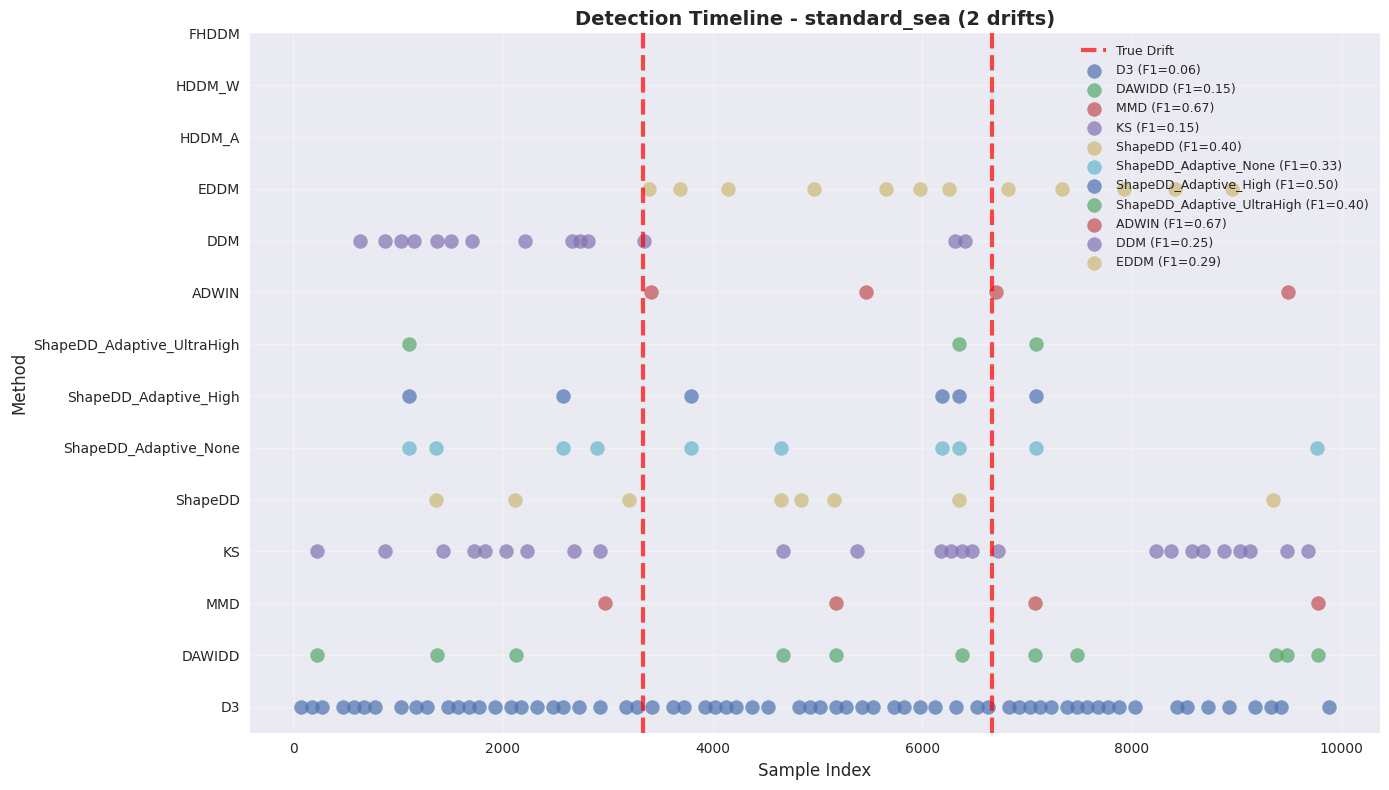

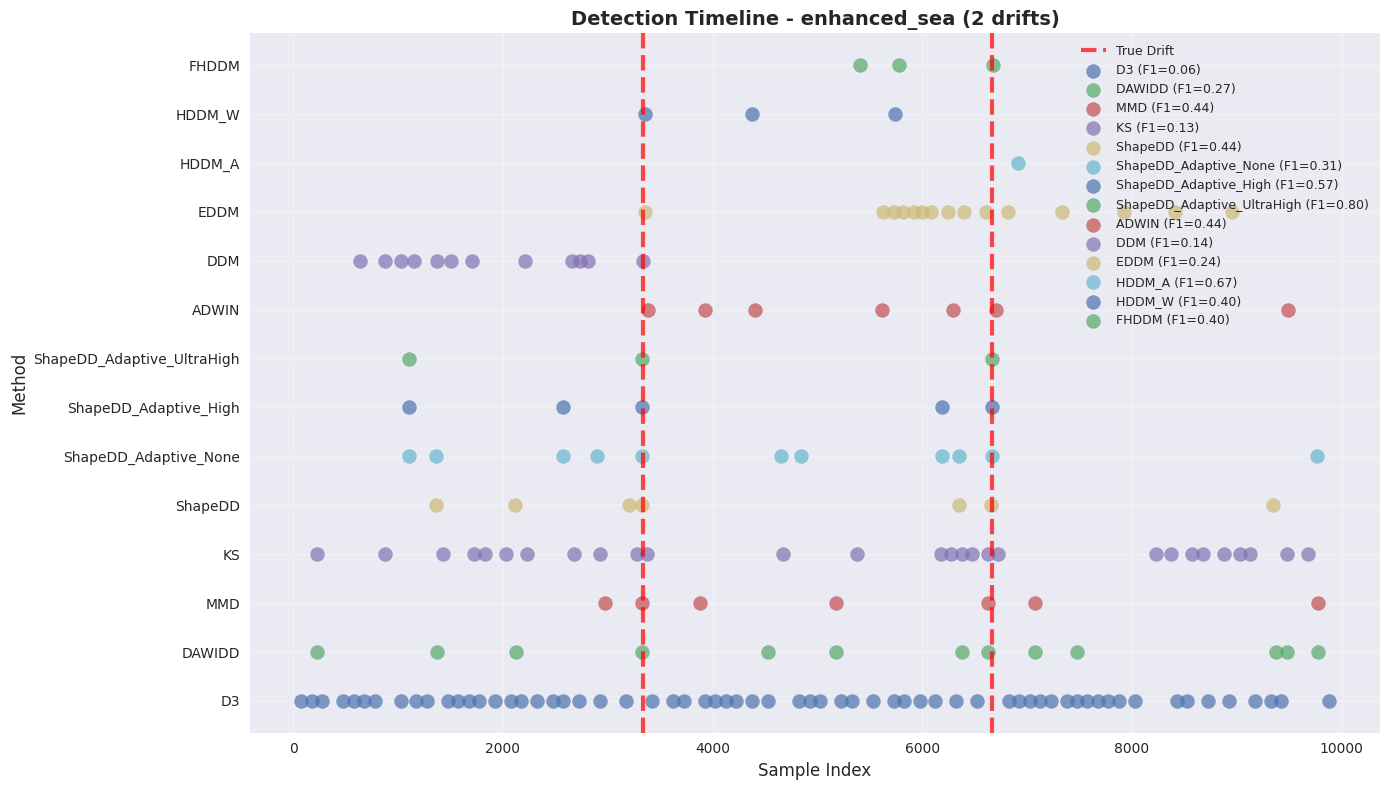

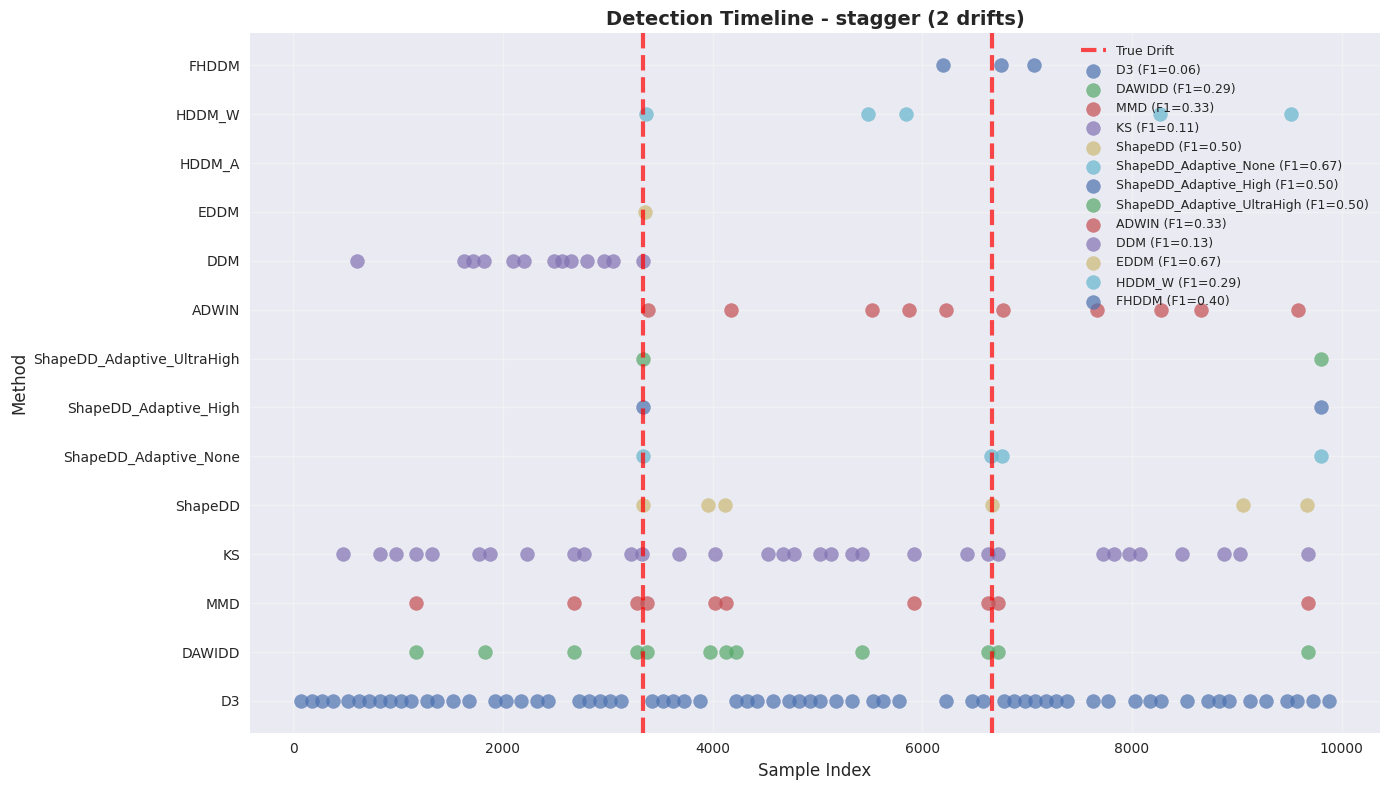

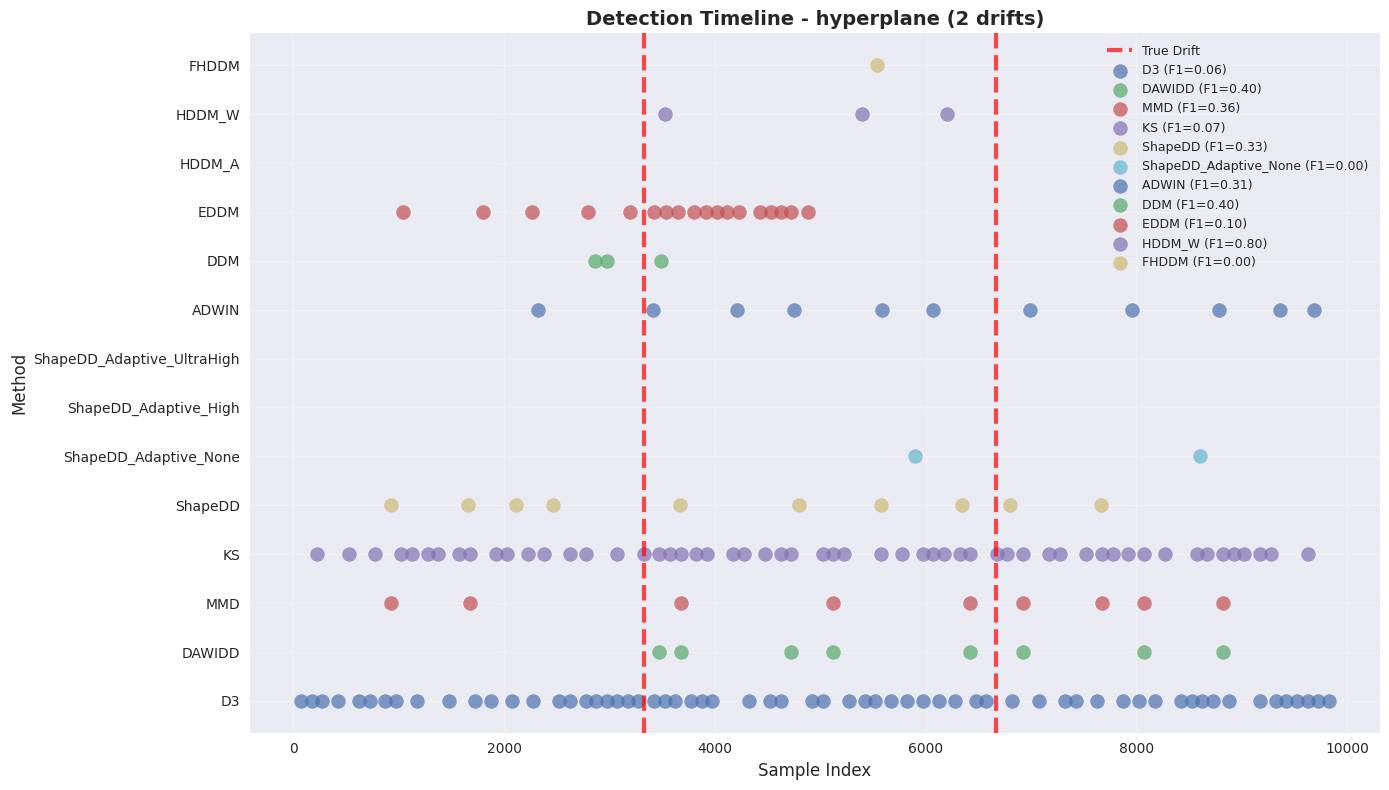

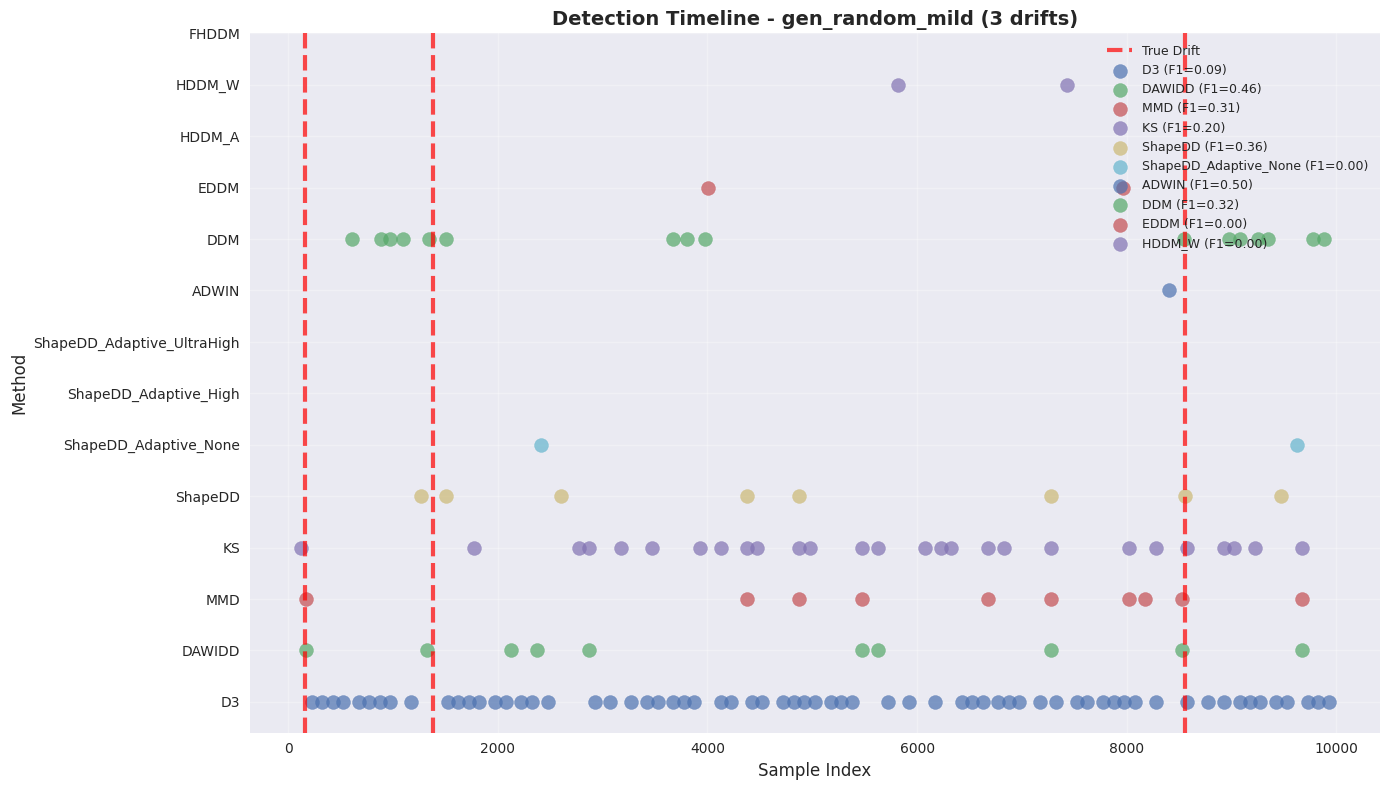

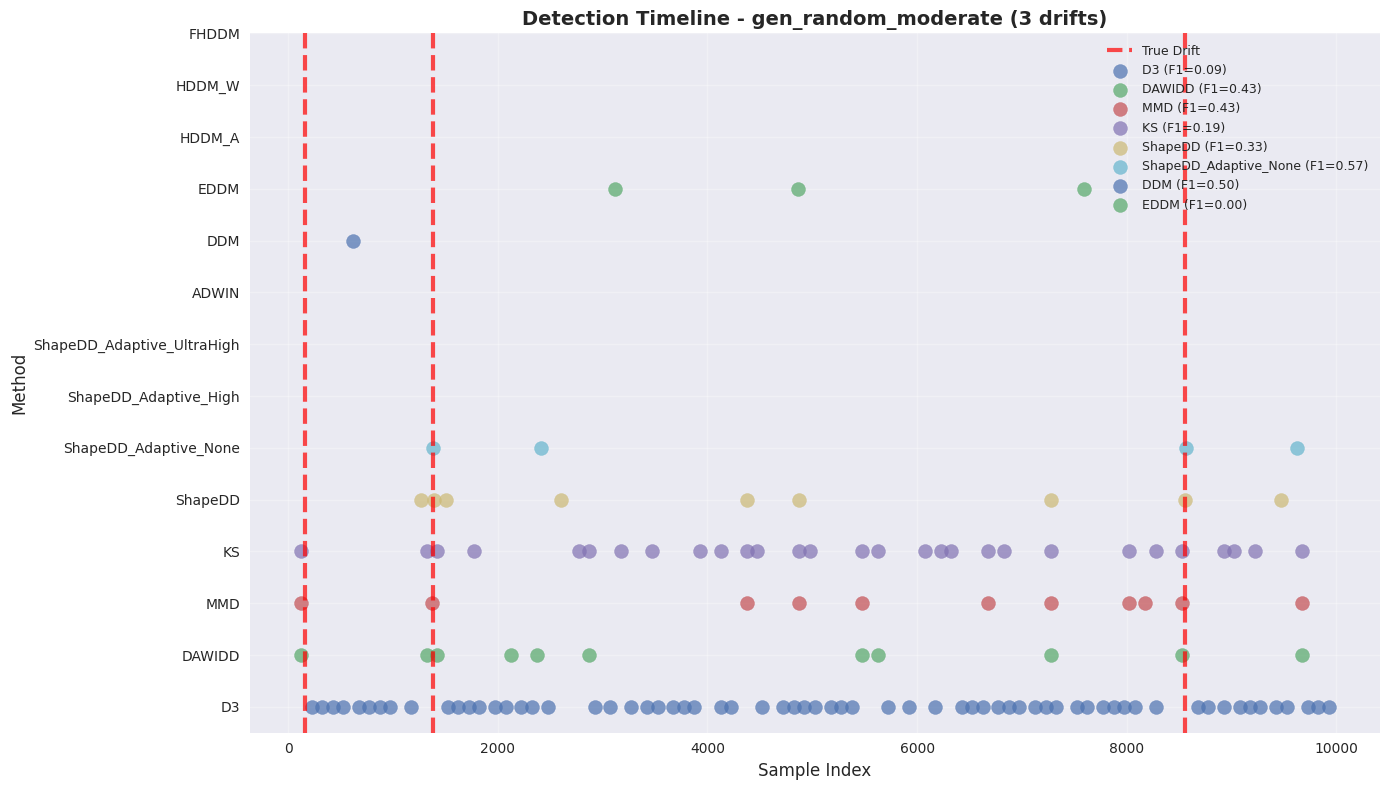

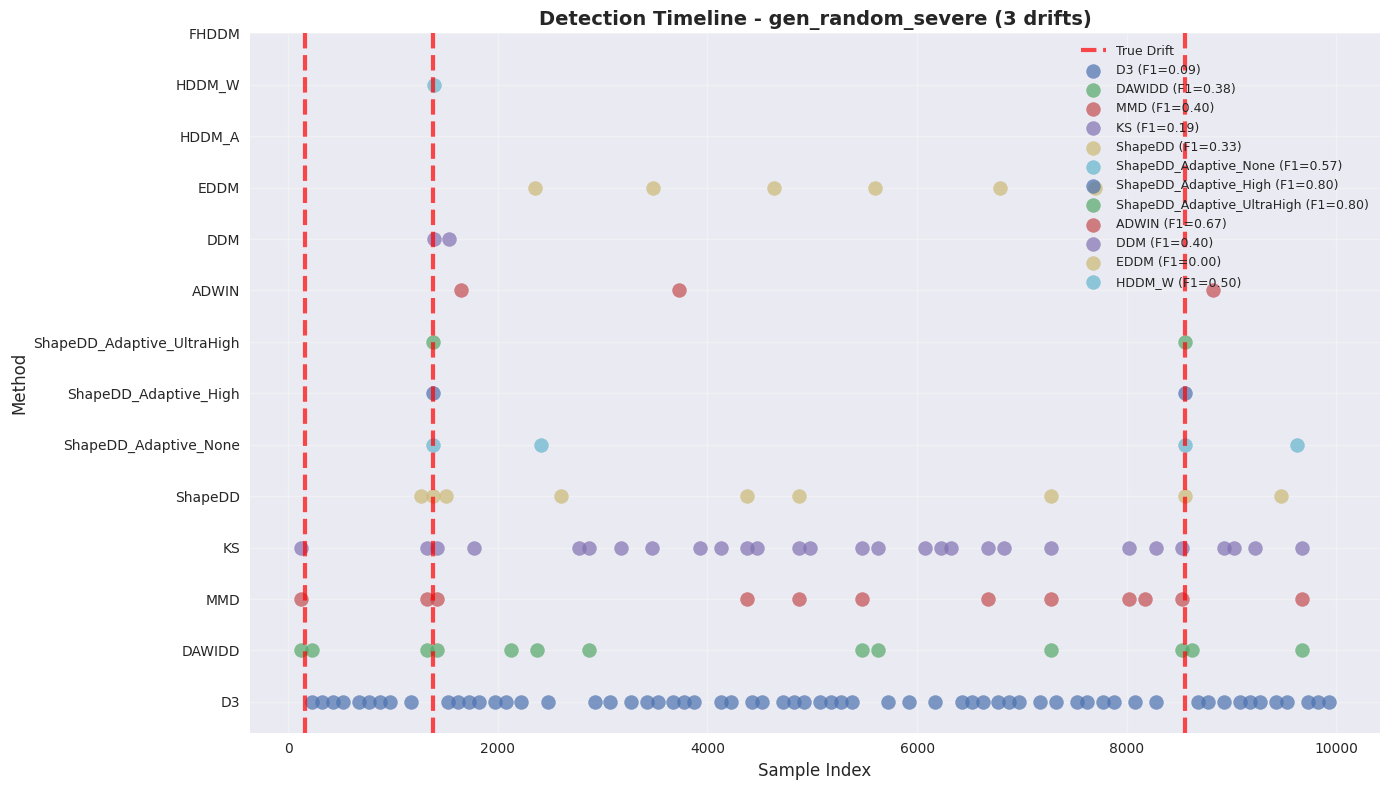

In [ ]:
# ============================================================================
# SECTION 8: VISUALIZATION - DETECTION TIMELINES
# ============================================================================

if len(all_results) == 0:
    print("⚠ No results to visualize")
else:
    datasets = results_df['Dataset'].unique()

    for dataset_name in datasets:
        dataset_results = [r for r in all_results if r['dataset'] == dataset_name]

        if not dataset_results:
            continue

        true_drifts = dataset_results[0]['drift_positions']
        n_drifts = len(true_drifts)

        fig, ax = plt.subplots(figsize=(14, 8))

        # Plot true drifts
        for i, drift_pos in enumerate(true_drifts):
            ax.axvline(drift_pos, color='red', linestyle='--', linewidth=3,
                      alpha=0.7, label='True Drift' if i == 0 else '')

        # Plot detections
        for idx, result in enumerate(dataset_results):
            detections = result['detections']
            method = result['method']

            if detections:
                ax.scatter(detections, [idx]*len(detections), s=100, alpha=0.7,
                          label=f"{method} (F1={result['f1_score']:.2f})")

        ax.set_yticks(range(len(dataset_results)))
        ax.set_yticklabels([r['method'] for r in dataset_results])
        ax.set_xlabel('Sample Index', fontsize=12)
        ax.set_ylabel('Method', fontsize=12)
        ax.set_title(f'Detection Timeline - {dataset_name} ({n_drifts} drifts)',
                    fontsize=14, fontweight='bold')
        ax.legend(loc='upper right', fontsize=9)
        ax.grid(alpha=0.3)

        plt.tight_layout()
        plt.show()



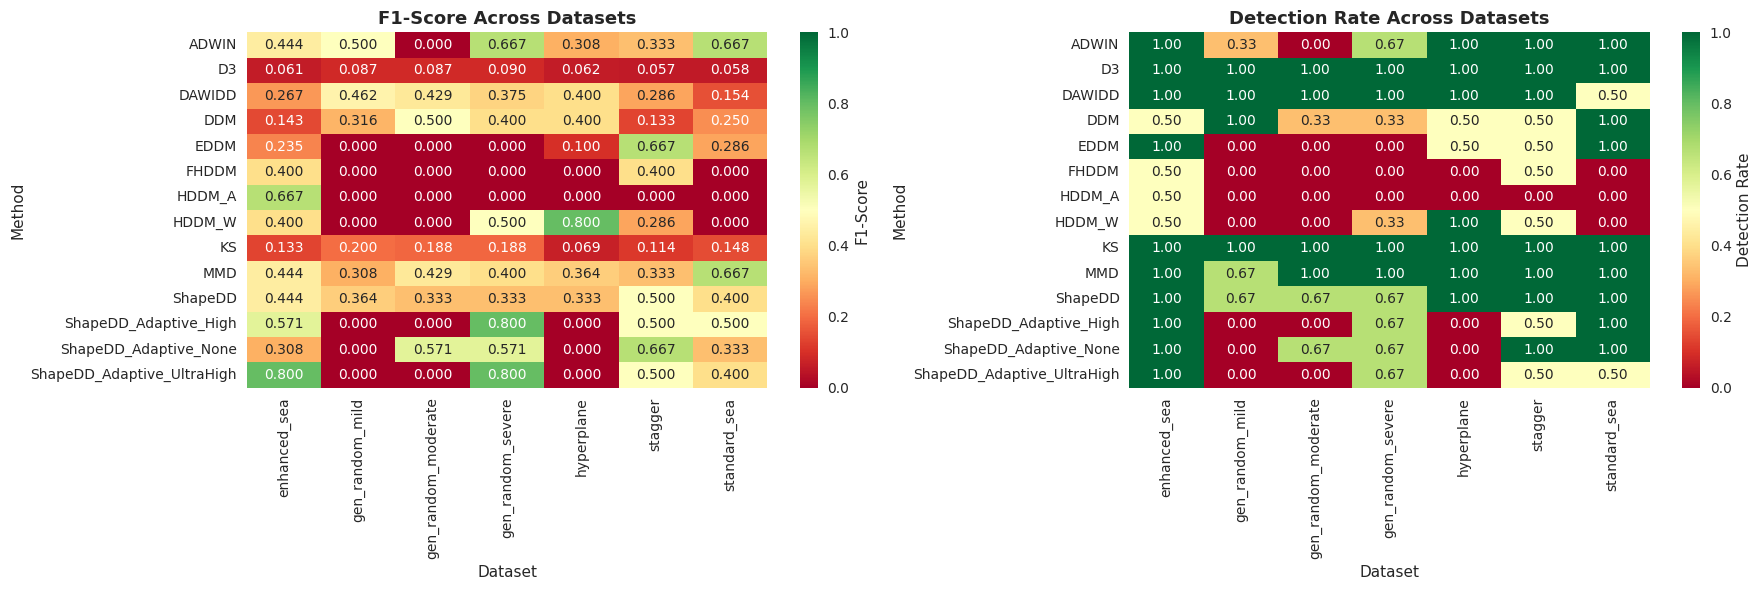

In [ ]:
# ============================================================================
# SECTION 9: VISUALIZATION - PERFORMANCE HEATMAP
# ============================================================================

if len(all_results) == 0:
    print("⚠ No results to visualize")
else:
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    # F1-Score heatmap
    ax = axes[0]
    f1_pivot = results_df.pivot_table(values='F1', index='Method',
                                       columns='Dataset', aggfunc='mean')
    sns.heatmap(f1_pivot, annot=True, fmt='.3f', cmap='RdYlGn',
               vmin=0, vmax=1, cbar_kws={'label': 'F1-Score'}, ax=ax)
    ax.set_title('F1-Score Across Datasets', fontsize=13, fontweight='bold')

    # Detection Rate heatmap
    ax = axes[1]
    dr_pivot = results_df.pivot_table(values='Detection_Rate', index='Method',
                                       columns='Dataset', aggfunc='mean')
    sns.heatmap(dr_pivot, annot=True, fmt='.2f', cmap='RdYlGn',
               vmin=0, vmax=1, cbar_kws={'label': 'Detection Rate'}, ax=ax)
    ax.set_title('Detection Rate Across Datasets', fontsize=13, fontweight='bold')

    plt.tight_layout()
    plt.show()

